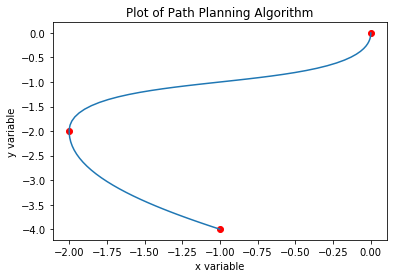

done


In [21]:
import pathfinder as pf
import math
import numpy as np
from pathFunc import *

#change these points and run file
points = [
    pf.Waypoint(-4, -1, math.radians(-45.0)),   # Waypoint @ x=-4, y=-1, exit angle=-45 degrees
    pf.Waypoint(-2, -2, 0),                     # Waypoint @ x=-2, y=-2, exit angle=0 radians
    pf.Waypoint(0, 0, 0),                       # Waypoint @ x=0, y=0,   exit angle=0 radians
]
# # points = [pf.Waypoint(-4, -1, math.radians(-45.0)), pf.Waypoint(-2, -2, 0), pf.Waypoint(0, 0, 0),]
# info, trajectory = pf.generate(points, pf.FIT_HERMITE_CUBIC, pf.SAMPLES_HIGH, dt=0.05,max_velocity=1.7,max_acceleration=2.0,max_jerk=60.0)


# modifier = pf.modifiers.TankModifier(trajectory).modify(0.5) #0.5 is the width of the wheelchair base need to change
# right = modifier.getRightTrajectory()
# left = modifier.getLeftTrajectory()

# for i in np.arange(len(right)):
#     print(right[i])

info, trajectory = path(points)
plot(points, trajectory)

print('done')

1.7 -2.5500000000000007


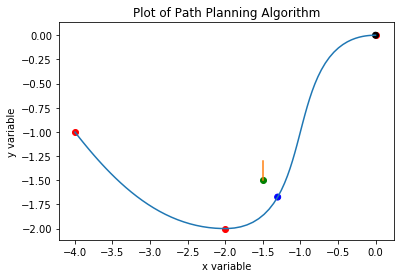

1.0


In [75]:
ptx, pty = -1.5, -1.5
heading = math.pi/2

pos = (ptx, pty)
ang = heading
traj = trajectory

# MATH
cst = get_closest(traj, pos)
x, y, t_ind = lookahead(traj, pos, 0.5)
c = curvature(traj, pos, x, y, ang)

print(traj[cst].velocity, traj[cst].velocity * c)

inds = [cst, t_ind]

# plot the waypoints
mx, my = zip(*[(m.x, m.y) for m in points])
plt.scatter(mx, my, c="r")

# plot the trajectory
x, y = zip(*[(seg.x, seg.y) for seg in traj])
plt.plot(x, y)

plt.scatter([traj[i].x for i in inds], [traj[i].y for i in inds], c='bk')
plt.scatter(ptx, pty, c='g')
plt.plot([ptx, ptx + 0.2*math.cos(heading)], [pty, pty + 0.2*math.sin(heading)])

plt.xlabel('x variable')
plt.ylabel('y variable')
plt.title('Plot of Path Planning Algorithm')
plt.show()

bang_bang(traj, pos, ang)

In [72]:
def bang_bang(traj, pos, ang):
    cst = get_closest(traj, pos)
    x, y, v = traj[cst].x, traj[cst].y, traj[cst].velocity
    side = np.sign(math.sin(math.pi/2 - ang)*(x-pos[0]) - math.cos(math.pi/2 - ang)*(y-pos[1]))
    
    return v, ()


In [67]:
def get_closest(traj, pos):
    ind=0
    d_min=float('Inf')
    for i, pt in enumerate(reversed(traj)):
        dist = math.sqrt((pt.x-pos[0])**2 + (pt.y-pos[1])**2)
        if dist < d_min:
            ind = i
            d_min = dist
    return len(traj) - ind - 1

def lookahead(traj, pos, r):
    if math.sqrt(traj[-1].x**2 + traj[-1].y**2) < r:
        x, y = traj[-1].x, traj[-1].y
        t_ind = len(traj) - 1
        return x, y, t_ind
    
    x, y = 0, 0
    t_ind = 0
    for i, pt in enumerate(reversed(traj[:-1])):
        j = len(traj) - 2 - i
        d = (traj[j+1].x - pos[0], traj[j].y - pos[1])
        f = (pt.x - pos[0], pt.y - pos[1])
        
        a = sum(x**2 for x in d)
        b = 2*sum(x * y for x, y in zip(d, f))
        c = sum(y**2 - r**2 for y in f)
        
        disc = b**2 - 4*a*c
        if disc >= 0:
            disc = math.sqrt(disc)
            t1 = (-b - disc) / (2*a)
            t2 = (-b + disc) / (2*a)
            
            if (t1 >= 0 and t1 <= 1):
                x, y = pt.x + t1*d[0], pt.y + t1*d[1]
                t_ind = j
                print("found pt")
                return x, y, t_ind
            if (t2 >= 0 and t2 <= 1):
                x, y = pt.x + t2*d[0], pt.y + t2*d[1]
                t_ind = j
                print("found pt")
                return x, y, t_ind
                
    ind = get_closest(traj, pos)
    x, y = traj[ind].x, traj[ind].y
    return x, y, t_ind
    
def curvature(traj, pos, x, y, ang):
    ## Calculate curvature math
    side = np.sign(math.sin(math.pi/2 - ang)*(x-pos[0]) - math.cos(math.pi/2 - ang)*(y-pos[1]))
    a = -math.tan(math.pi/2 - ang)
    c = math.tan(math.pi/2 - ang)*pos[0] - pos[1]
    x = abs(a*x + y + c) / math.sqrt(a**2 + 1)
    return side * x

def find_vels(traj, pos, ang):
    cst = get_closest(traj, pos)
    x, y, t_ind = lookahead(traj, pos)
    c = curvature(traj, pos, x, y, ang)
    return traj[cst].velocity, traj[cst].velocity * c